# Introduction to object detection in deep learning

Starting with object localization:
- Detecting what object is present in the photo and giving a bounding box

Object Localization is finding what and where a (single) object exists in an image.

Object detection is finding what and where (multiple) objects are in an image.

So how do we do Object localization?

While doing image classification we first used a CNN to find the class it belongs to. Now we will just add some extra outputs, which will be responsible for telling the bounding box of the detected object.

We need atleast 4 points to define a bouding box.

2 common ways to define Bounding Boxes:
1) upper left and bottom right corner point
2) define a corner point and then height and width

CE loss can be used for the prediction part, and L2/MSE can be used for the bounding boxes predicted.

Alright, so localization is no big deal.

But, how do we generalise this approach for multiple objects in an image?

There are many approaches to solving object detection and each is in many ways unique.

"Natural" extention of Object localization for object detection is the Sliding Windows approach.

Take a particular crop size and step it throughout the input image with some big step size, then for each of the crops run it through an object localization CNN.
And then after each time running through you change the size of the crop.

Note: The sliding window is generally a square.

Problems with this method?
1) A LOT of computation --> one way to reduce this is pasisng the original image through the convnet directly and it would just output a different shape of output, each corresponding to each crop --> but still a lot of computation
2) Many bouding boxes for same object

<br>

Another possible method to implement Object Detection is to use Regional Based Networks (Region Proposal (R-CNN)):

Take the input image, extract region proposal (~2k) and now run each of those regions through a ConvNet to classify the region.

This does reduce the number of computation. There are 3 papers on this topic: R-CNN, Fast rCNN, Faster rCNN

Regional Based Networks is still slow, and a complicated 2 step process the more you think about it

#### YOLO - You Only Look Once

You divide the input image in a SxS grid. Each cell of the grid is responsible for outputting two things:
1) A class probability indicating which class it belongs to
2) A bounding box with a confidence score

Both of these are used to output the final detections using NMS.

## Intersection Over Union

How do we measure how good a bounding box is?

Given correct bounding box and a predicted box. We will calculate the intersection of those bounding boxes and then calculate the union of those two bouding boxes.

Intersection over Union is a metric for deciding how good of a prediction you made.

IoU = Area of Intersection / Area of Union

1) IoU > 0.5 "decent"
2) IoU > 0.7 "pretty good"
3) IoU > 0.9 "perfect"


How do we get the intersection? We are just given 4 numbers for each of the two boxes.

NOTE: Origin is at top left.

### Calculation of IoU

For Intersection box:

x1 = max(box1[x1], box2[x1]) <br>
y1 = max(box1[y1], box2[y1]) <br>
x2 = min(box1[x2], box2[x2]) <br>
y2 = min(box1[y2], box2[y2]) <br>

This can be made clear from the below diagram:
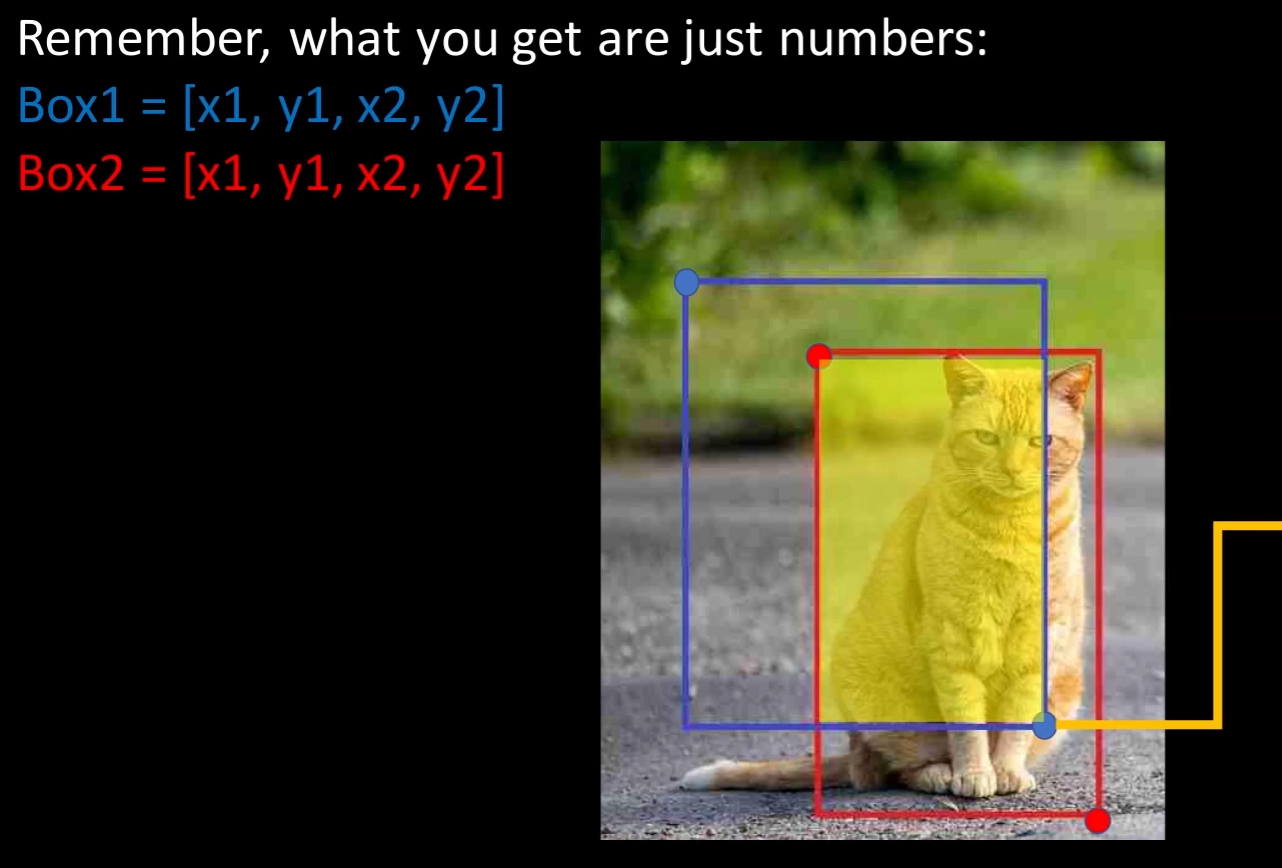


For Union box: ? The shape is a bit complex so we won't exactly find the coordinate to get the area, instead we will just do simple math

Area of Union = Area of box1 + Area of box2 - Area of intersection!

Now just divide and return!

## Non Max Supression

Goal is Cleaning up bounding box predictions.

For a single object we may get multiple bounding box predictions (from adjacent cells of YOLO for example)

First discard bounding boxes which have probability less than some threshold.

Now, we need to go through each of those predicted boxes and just take the one which has the highest confidence (and also a good IoU)

In Non-Max Suppression you take the box with the highest confidence and then take it's IoU with other boxes.

If the IoU between those two boxes is higher than 0.5 then remove the other box from the set of predictions

If you have multiple classes, do it seperately for each class.

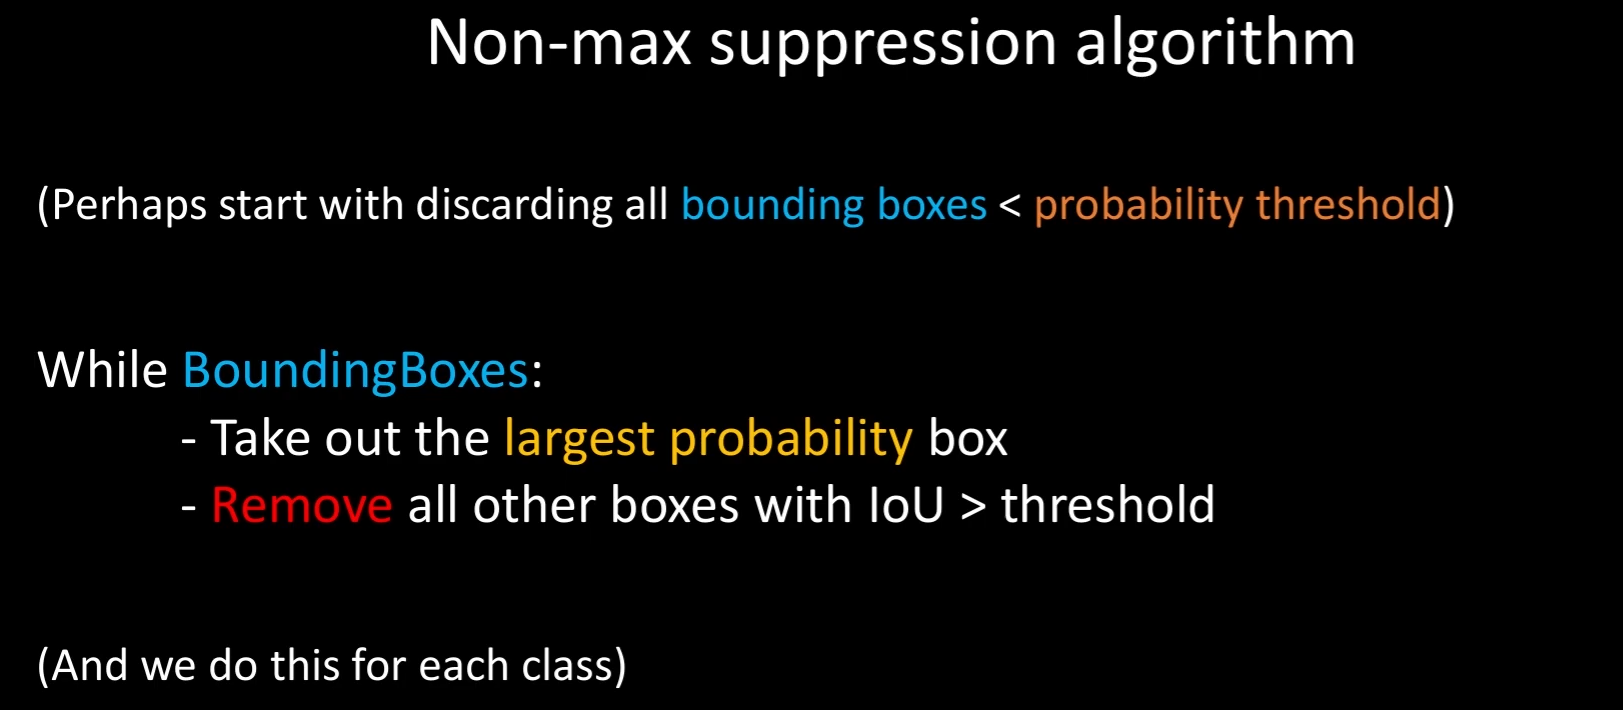

## Mean Average Precision

Goal is to understand and implement the most common metric for object detection models.

The first step in Mean Average Precision:
1) Get all the bounding boxes predicted on the entire test set. Classify each of the bounding box on each image as a True Positive or False Positive based on IoU with actual class object
2) Sort all the bouding boxes in a descending confidence score.

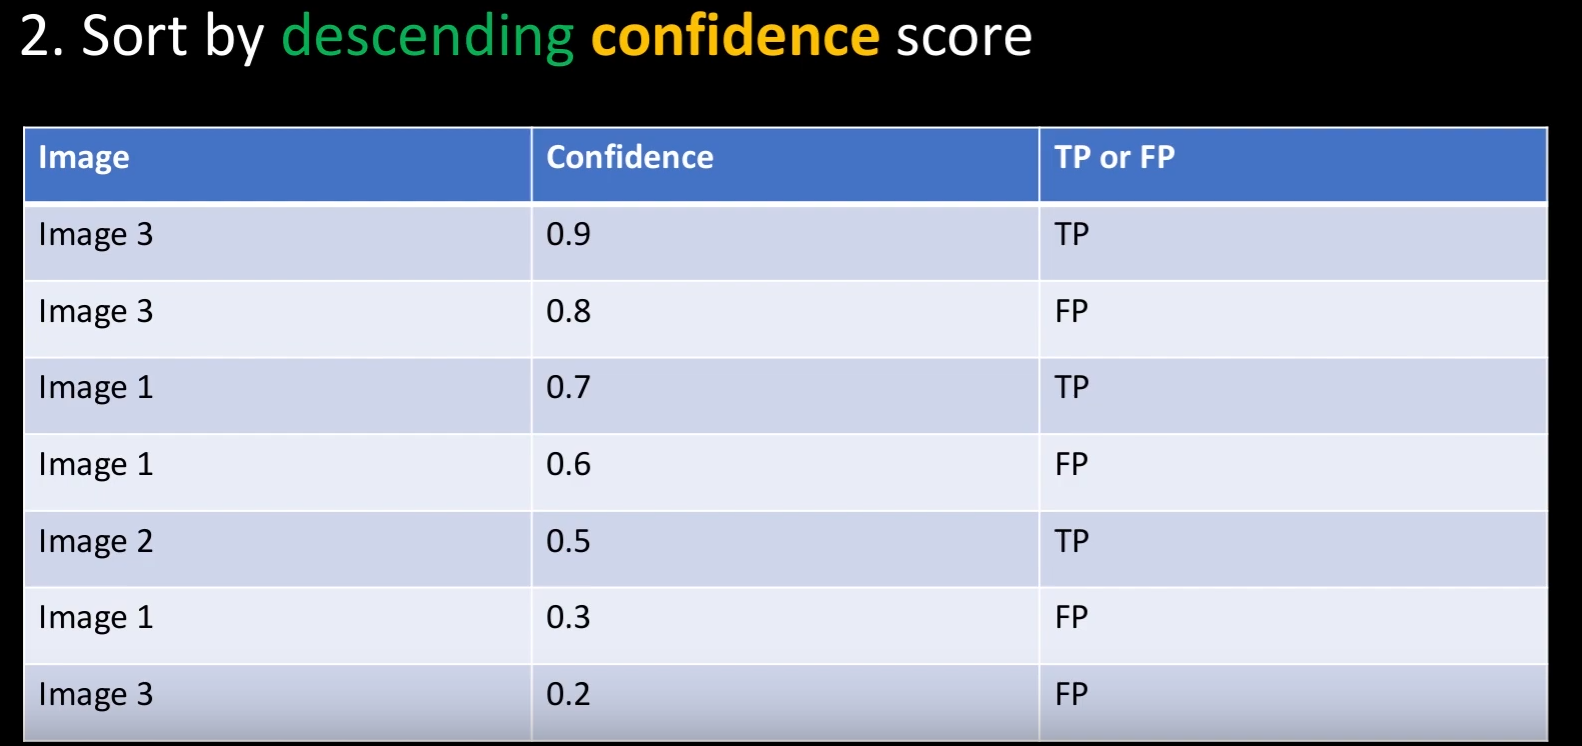

3) Calculate Precision and Recall as we go through all outputs.

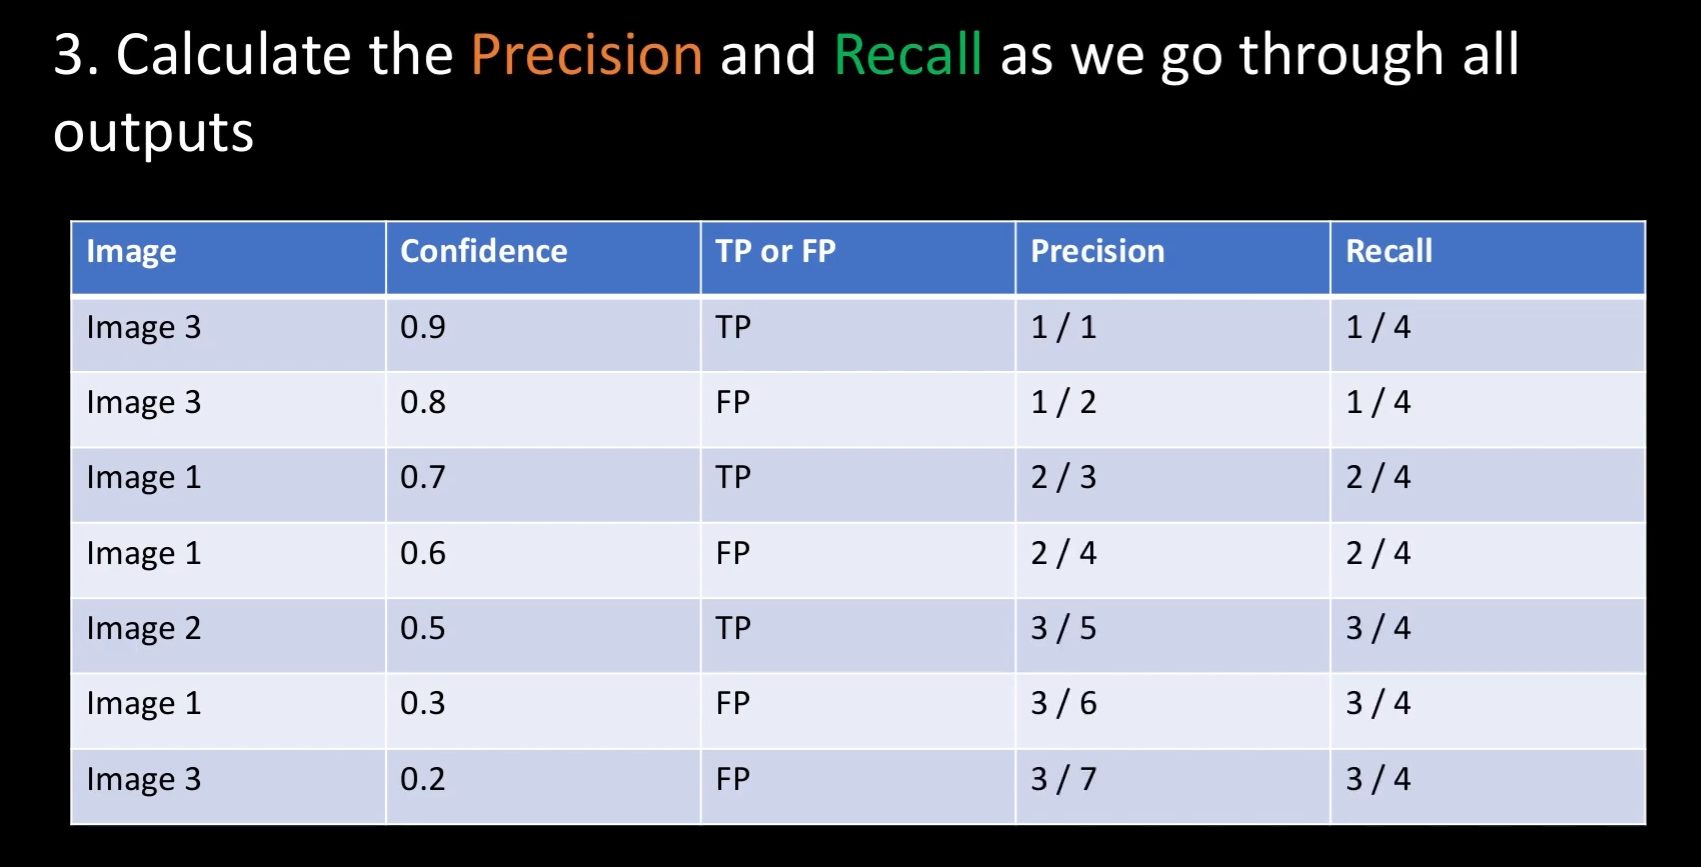

4) Plot the Precision-Recall Curve
5) Calculate Area under PR Curve

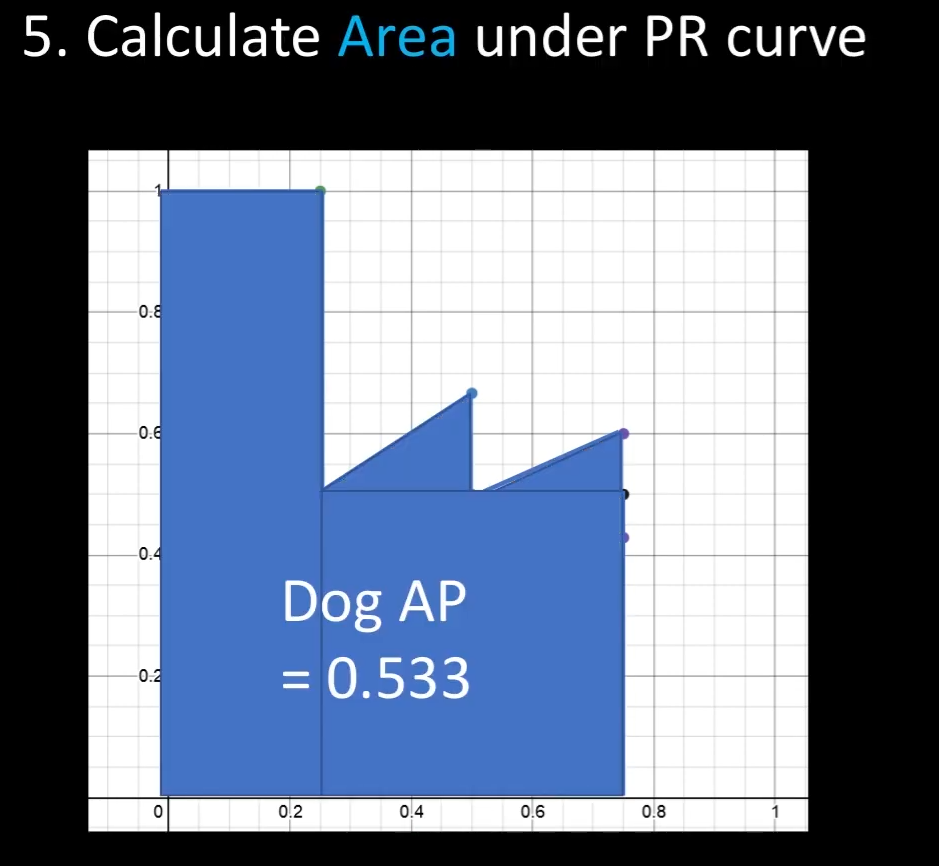

6) This was everything for one class, do this for all classes and find mean.

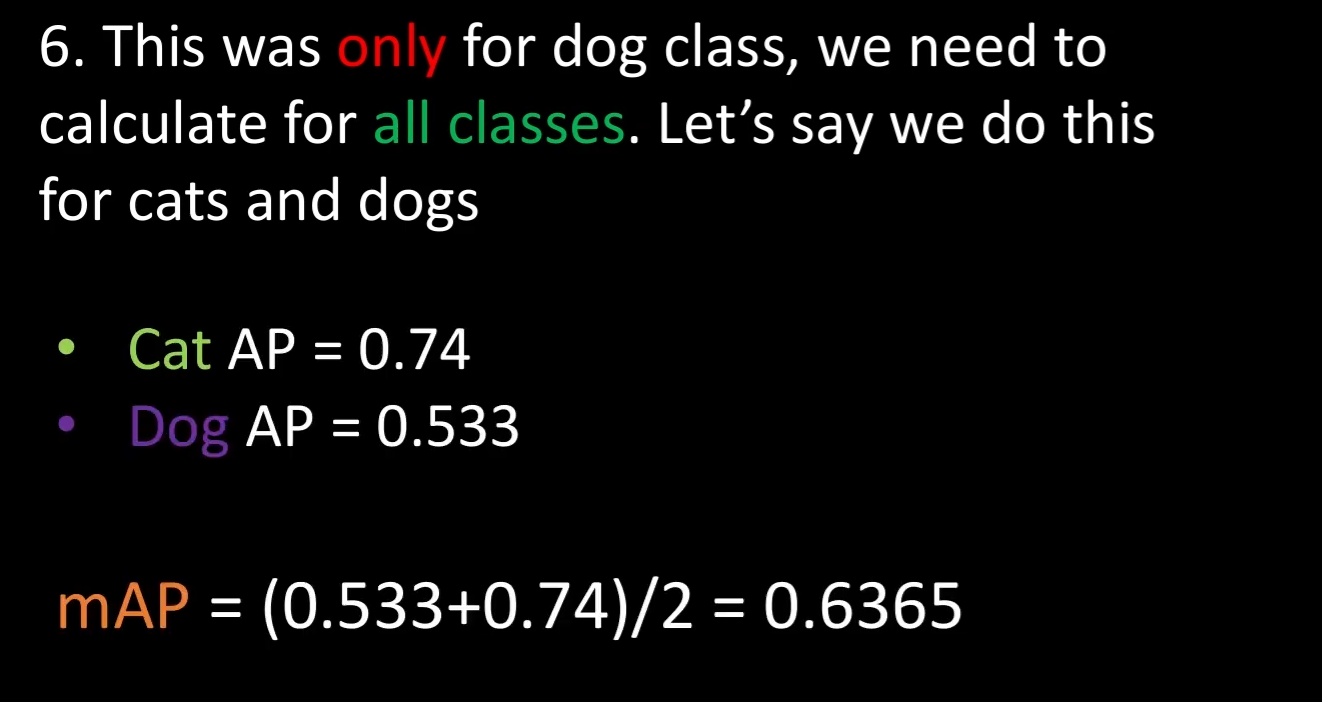
WE ARE STILL NOT DONE!

7) All these calculations were done for a specific IoU threshold of 0.5, we need to redo all computations for many IoU's, for example: 0.5, 0.55, 0.6, ..., 0.95 (mAP@0.5:0.05:0.95). Then average this and this will be our final result!



NOTE: 
1) True positive are the predicted bounding boxes that share an IoU of > 0.5 with an object of that class in that area, and False Positives are the ones that don't.
2) Precision = True Postives/ (True Positives + False Positives) (Of all the bounding box predictions made how many are correct)
3) Recall = True Positives/ Total number of positives (How many of the actual true classes was it able to recall/ detect)(of all the target bounding boxes, what fraction did we correctly detect)

# YOLOv1

YOLO was trained on PASCAL VOC Dataset having 20 classes. Most papers now-a-days use COCO dataset.

Our goal is given an image output the bounding box and classes of various objects in that image.

Steps:
1) Split into SxS grid.
2) Each cell (0->1 staring from top left along each axis) will output a prediction with a cooresponding bounding box (Bounding box is in midpoint format and all coordinates are relative to the current cell!)
3) We assume the cell which contains the midpoint of the object is responsible for predicting that object. (Note that height and width can be larger than 1)

How will the labels look like?

For each object: <br>
label = [c1, c2, c3, ..., c20, pc, x, y, w, h]

and, For each cell we will have two anchor boxes: <br>
pred = [c1, c2, c3, ..., c20, p1, x, y, w, h, p2, x, y, w, h]

NOTE: Each cell can only detect one object!

Target Shape: (S, S, 25) <br>
Prediction Shape: (S, S, 30)

## Model Architecture

Input: 448x448x3

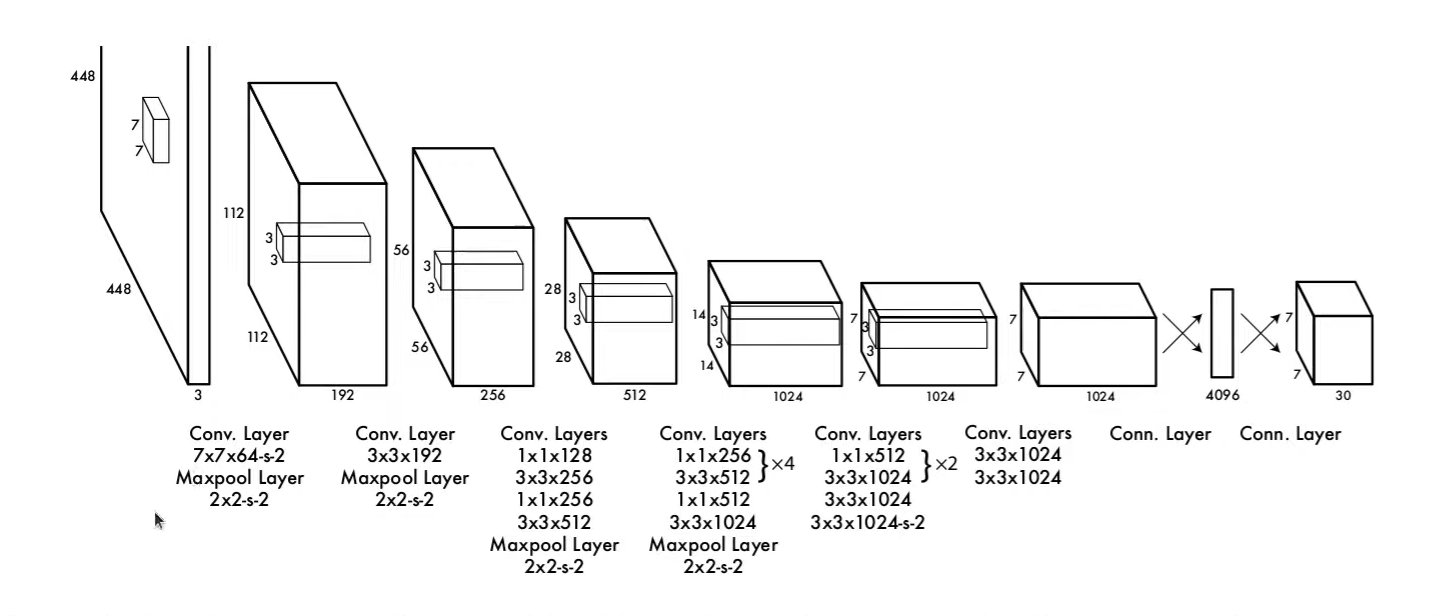

## Loss function

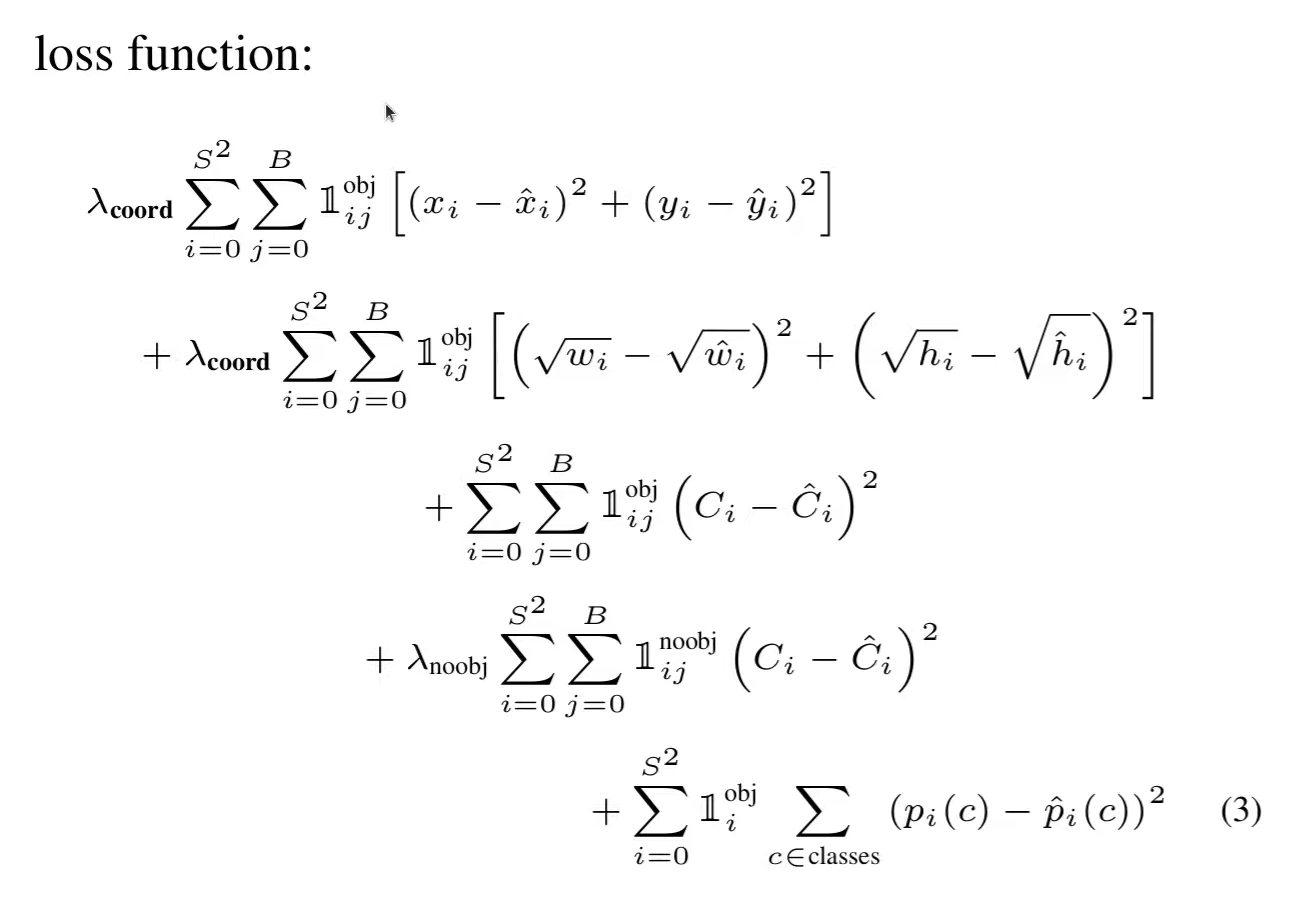


1<sup>obj</sup> is an identity function which is 1 when the ith block contains the midpoint of the jth object and is responsible for predicting it.

c stands for probability there is an object in the box.

We use MSE loss for everything